# Habitat Simulation with NoMaD Navigation - Notebook Version

This notebook demonstrates how to run the NoMaD policy in Habitat simulation.

In [1]:
# Import the main module
import sys

import habitat_sim
from src.controller.ShortestPathFollower import SimShortestPathFollower
from src.env.HabitatSimulator import HabitatSimulator
from src.policy.NoMaDPolicy import NoMaDPolicy
from src.controller.action_conversion import WaypointToActionConverter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display
import imageio
from PIL import Image
import src.llm as llm

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


pybullet build time: Sep 30 2025 00:53:55


## Configuration

Set your paths here:

In [2]:
# Configuration
SCENE_PATH = "/home/liuxh/vln/nomad-habitat/habitat-sim/data/versioned_data/mp3d_example_scene_1.1/17DRP5sb8fy/17DRP5sb8fy.glb"
SCENE_PATH = "/home/liuxh/vln/nomad-habitat/habitat-sim/data/scene_datasets/habitat-test-scenes/skokloster-castle.glb"
SCENE_PATH = "../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/wcojb4TFT35.basis.glb"
# SCENE_PATH = "habitat-sim/data/scene_datasets/habitat-test-scenes/apartment_1.glb"
MODEL_CONFIG = "../algorithm/visualnav-transformer/train/config/nomad.yaml"
MODEL_WEIGHTS = (
    "../algorithm/visualnav-transformer/deployment/model_weights/nomad.pth"
)
ROBOT_CONFIG = "../algorithm/src/config/robot.yaml"


NUM_STEPS = 600
WAYPOINT_INDEX = 2
NUM_SAMPLES = 8
CONTEXT_WARMUP = 12
DEVICE = "cuda"
FORWARD_DISTANCE = 0.1
TURN_ANGLE = 5

## Initialize Simulator and Policy

In [3]:
# Initialize Habitat simulator
print("Initializing Habitat simulator...")
sim = HabitatSimulator(scene_path=SCENE_PATH, enable_physics=True, resolution=(480, 640))
sim.initialize()
print("✓ Habitat simulator initialized.")

# Initialize NoMaD policy
print("Initializing NoMaD policy...")
policy = NoMaDPolicy(
    model_config_path=MODEL_CONFIG, model_weights_path=MODEL_WEIGHTS, device=DEVICE
)
print("✓ NoMaD policy initialized.")

Initializing Habitat simulator...
Renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 580.105.08
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
✓ Habitat simulat

[14:47:34:231857]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[14:47:34:232147]:[Warning]:[Scene] SemanticScene.h(331)::checkFileExists : ::loadSemanticSceneDescriptor: File `../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/wcojb4TFT35.basis.scn` does not exist.  Aborting load.
[14:47:34:232173]:[Warning]:[Scene] SemanticScene.cpp(123)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/wcojb4TFT35.basis.scn` nor constructed filename : `../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/info_semantic.json` exist on disk.
[14:47:34:232190]:[Error]:[Scene] SemanticScene.cpp(139)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `../habi

✓ NoMaD policy initialized.


# 暂定目标：遥感图像处理

In [4]:
# 初始化
follower = SimShortestPathFollower(sim.sim, agent_id=0, goal_radius=0.05)

import gzip
import json

with gzip.open("/home/liuxh/vln/nomad-habitat/habitat-lab/data/datasets/objectnav/hm3d/v2/objectnav_hm3d_v2/val_mini/content/TEEsavR23oF.json.gz", "rt", encoding="utf-8") as f:
    data = json.load(f)

start_pos=data['episodes'][1]['start_position']


## Run Exploration

In [ ]:

# Recording containers
sim.sim.reset(sim.sim._default_agent_id)
state=sim.sim.get_agent(0).get_state()
state.position=start_pos
sim.sim.get_agent(0).set_state(state)
traj_frames = []
trajectory_grid_points = []
obs_video = []
print(f"Starting exploration for {NUM_STEPS} steps...")
NUM_STEPS = 400
nav_area = {}
# Exploration loop
for step in range(NUM_STEPS ):

    rgb_img = sim.get_observation()
    obs_video.append(rgb_img)
    # Add to policy context
    policy.add_observation(rgb_img)

    # Get agent position and update trajectory
    position = sim.get_agent_position()
    if sim.sim.pathfinder.get_island(position) not in nav_area:
        nav_area[sim.sim.pathfinder.get_island(position)] = 1
    
    grid_loc = sim.world_to_map(position)
    trajectory_grid_points.append(grid_loc)
    map_frame = sim.draw_trajectory(trajectory_grid_points)
    traj_frames.append(map_frame)
    # Predict action after enough context
    action = []
    cumulate_action = []
    if step < CONTEXT_WARMUP:
        # Random exploration during warmup
        action.append(np.random.choice(["move_forward", "turn_left", "turn_right"]))
        if step % 10 == 0:
            print(f"Step {step}: Warmup - {action}")
    else:
        # Use policy to predict waypoint
        if step >=100:
            result = policy.predict_waypoint(waypoint_index=WAYPOINT_INDEX, num_samples=NUM_SAMPLES, mask=True, goal = rgb_img)
        else:
            result = policy.predict_waypoint(waypoint_index=WAYPOINT_INDEX, num_samples=NUM_SAMPLES)
        waypoint, trajectory = result

        

        if result is not None:
            # action = control.sequential_convert(waypoint=waypoint)
            target_pos = follower.local_to_global(waypoint)  # 旋转+投影到可行走区域
            action = follower.get_next_action(target_pos)

            if step % 4 == 0:
                print(f"Step {step}: Predicted waypoint {waypoint} -> {action}")

    # Execute action
    if not action:
        sim.step({})
    else:
        if isinstance(action, str):
            action = [action]
        for act in action:
            t=sim.step(act)

    




print("✓ Exploration completed.")

Starting exploration for 600 steps...
Step 0: Warmup - ['turn_right']
Step 10: Warmup - ['turn_left']
Inference time: 0.229s
Step 12: Predicted waypoint [ 2.5630033  -0.11128712] -> turn_right
Inference time: 0.071s
Step 16: Predicted waypoint [ 2.7786558  -0.10668254] -> turn_right
Inference time: 0.071s
Step 20: Predicted waypoint [ 2.4486518  -0.12072587] -> turn_right
Inference time: 0.072s
Step 24: Predicted waypoint [2.7197335  0.22441578] -> turn_right
Inference time: 0.071s
Step 28: Predicted waypoint [3.100697   0.11270332] -> turn_right
Inference time: 0.072s
Step 32: Predicted waypoint [ 3.1244648  -0.19065094] -> move_forward
Inference time: 0.072s
Step 36: Predicted waypoint [2.990548   0.20506096] -> move_forward
Inference time: 0.080s
Step 40: Predicted waypoint [ 3.0689876  -0.09191132] -> move_forward
Inference time: 0.071s
Step 44: Predicted waypoint [ 2.5222375  -0.23801136] -> move_forward
Inference time: 0.071s
Step 48: Predicted waypoint [2.1161714  0.31746292] ->

In [30]:
# --- 新增：初始化 LLM/VLM + 目标/子目标管理 ---
from src.llm import (
    LLMClient, VLMClient, ImageMemory,
    NavigationGPrompt, NavigationController, PromptLogger
)

image_memory = ImageMemory()

llm_client = LLMClient(base_url="http://localhost:8081/v1", model="qwen-vl")
vlm_client = VLMClient(base_url="http://localhost:8081/v1", model="qwen-vl")

logger = PromptLogger("llm_prompts.jsonl")
gprompt = NavigationGPrompt(image_memory, logger=logger)
nav_controller = NavigationController(llm_client, vlm_client, image_memory, logger=logger)

goal_text = "浴室"

goal = gprompt.build(
    scene_description="indoor navigation scene",
    goal_text=goal_text
)

current_subgoal_idx = None
final_goal_reached = False
index_to_image = {}
last_desc = ""

# Recording containers
sim.sim.reset(sim.sim._default_agent_id)
state = sim.sim.get_agent(0).get_state()
state.position = start_pos
sim.sim.get_agent(0).set_state(state)
traj_frames = []
trajectory_grid_points = []
obs_video = []
print(f"Starting exploration for {NUM_STEPS} steps...")
NUM_STEPS = 400
nav_area = {}

# Exploration loop
for step in range(NUM_STEPS):
    rgb_img = sim.get_observation()
    obs_video.append(rgb_img)

    # Add to policy context
    policy.add_observation(rgb_img)

    # --- VLM场景描述 + LLM选择子目标 ---
    if step % 16 == 0:
        last_desc = vlm_client.describe_image(
            rgb_img,
            prompt="Describe the scene for indoor navigation."
        )

        subgoal_reached = nav_controller.check_subgoal_reached(rgb_img)
        next_step = nav_controller.decide_next_step(
            goal=goal,
            current_observation=last_desc,
            subgoal_reached=subgoal_reached
        )

        if next_step == "select_subgoal":
            current_subgoal_idx = nav_controller.choose_subgoal(goal, last_desc)
            print(f"Step {step}: New subgoal selected (index {current_subgoal_idx}).")
        else:
            current_subgoal_idx = None

        if nav_controller.check_final_goal_reached(rgb_img, goal):
            final_goal_reached = True
            print(f"Final goal reached ({goal_text}).")

    # 采集候选子目标图像（index -> 原图）
    if step % 16 == 0:
        idx = image_memory.add_image(rgb_img, description=last_desc, tag="candidate")
        index_to_image[idx] = rgb_img

    # Get agent position and update trajectory
    position = sim.get_agent_position()
    if sim.sim.pathfinder.get_island(position) not in nav_area:
        nav_area[sim.sim.pathfinder.get_island(position)] = 1

    grid_loc = sim.world_to_map(position)
    trajectory_grid_points.append(grid_loc)
    map_frame = sim.draw_trajectory(trajectory_grid_points)
    traj_frames.append(map_frame)

    # Predict action after enough context
 
    if step < CONTEXT_WARMUP:
        action.append(np.random.choice(["move_forward", "turn_left", "turn_right"]))
        if step % 10 == 0:
            print(f"Step {step}: Warmup - {action}")
    else:

        if current_subgoal_idx is not None:
            subgoal_img = index_to_image.get(current_subgoal_idx, None)
            result = policy.predict_waypoint(
                waypoint_index=WAYPOINT_INDEX,
                num_samples=NUM_SAMPLES,
                mask=True,
                goal=subgoal_img
            )
        else:
            result = policy.predict_waypoint(
                waypoint_index=WAYPOINT_INDEX,
                num_samples=NUM_SAMPLES
            )

        if result is not None:
        # action = control.sequential_convert(waypoint=waypoint)
            waypoint, trajectory = result
            target_pos = follower.local_to_global(waypoint)  # 旋转+投影到可行走区域
            action = follower.get_next_action(target_pos)

            if step % 4 == 0:
                print(f"Step {step}: Predicted waypoint {waypoint} -> {action}")

    # Execute action
    if not action:
        sim.step({})
    else:
        if isinstance(action, str):
            action = [action]
        for act in action:
            t = sim.step(act)

print("✓ Exploration completed.")


Starting exploration for 400 steps...
Step 0: New subgoal selected (index None).
Step 0: Warmup - ['turn_left', 'turn_left']
Step 10: Warmup - ['turn_left', 'turn_left', 'move_forward', 'turn_left', 'turn_left', 'turn_right', 'move_forward', 'turn_right', 'turn_left', 'turn_left', 'turn_left', 'turn_left']
Inference time: 0.090s
Step 12: Predicted waypoint [ 2.1212502 -0.4356873] -> turn_left
Inference time: 0.086s
Inference time: 0.090s
Inference time: 0.086s
Step 16: New subgoal selected (index None).
Inference time: 0.090s
Step 16: Predicted waypoint [0.40988266 0.03208399] -> turn_left
Inference time: 0.091s
Inference time: 0.092s
Inference time: 0.091s
Inference time: 0.097s
Step 20: Predicted waypoint [0.6593478 0.5286317] -> turn_left
Inference time: 0.090s
Inference time: 0.090s
Inference time: 0.086s
Inference time: 0.090s
Step 24: Predicted waypoint [2.6080718  0.16204429] -> move_forward
Inference time: 0.088s
Inference time: 0.091s
Inference time: 0.090s
Inference time: 0.0

In [29]:
goal.text,next_step,current_subgoal_idx,last_desc,idx

('浴室',
 'final_goal',
 None,
 'This is a view from inside a room, looking toward an open doorway that leads into a closet.\n\n- **Foreground/Right Side**: A plain, light gray wall occupies most of the frame. The ceiling above it is textured white.\n- **Left Side (Through the Doorway)**: An open white door reveals a walk-in closet.\n  - Inside the closet, clothes are hanging on racks. The garments appear to be in various colors, including green, red, and black.\n  - On the floor of the closet, there is a white plastic laundry basket.\n  - A yellow pillow or cushion is visible on the floor near the basket.\n- **Overall Impression**: The scene suggests a typical residential setting, possibly a bedroom or hallway. The open door provides a glimpse into the functional space of the closet, while the plain wall in the foreground indicates the viewer is standing in an adjacent room. The image has a slightly soft or painterly quality.',
 24)

## Save and Display Video

In [6]:
# Save video
output_path = "src/results/habitat_mapframe_notebook.mp4"
print(f"Saving video to {output_path}...")
imageio.mimsave(output_path, traj_frames, fps=10)
print(f"✓ Video saved to {output_path}")

# Display in notebook
display(Video(output_path, width=1200))

Saving video to src/results/habitat_mapframe_notebook.mp4...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (214, 415) to (224, 416) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✓ Video saved to src/results/habitat_mapframe_notebook.mp4


In [26]:
# Save video
output_path1 = "src/results/habitat_obs_notebook.mp4"
print(f"Saving video to {output_path1}...")
imageio.mimsave(output_path1, obs_video, fps=10)
print(f"✓ Video saved to {output_path1}")

# Display in notebook
display(Video(output_path1, width=1200))

Saving video to src/results/habitat_obs_notebook.mp4...
✓ Video saved to src/results/habitat_obs_notebook.mp4


## Visualize a Sample Frame

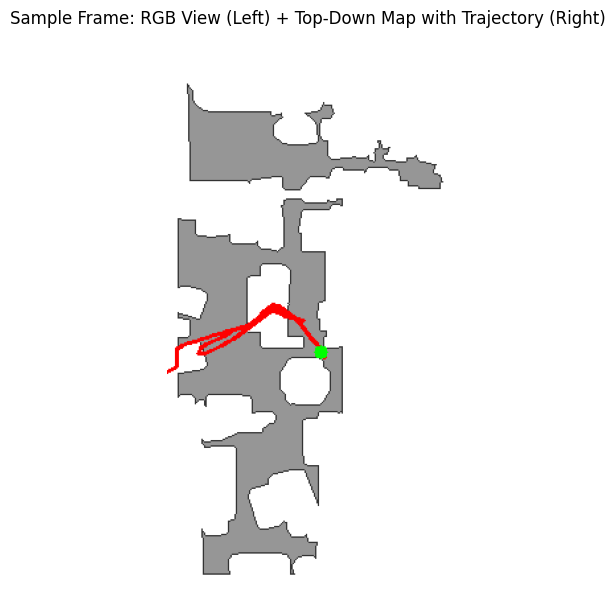

In [13]:
# Show a sample frame
sample_frame = traj_frames[len(traj_frames) // 2]

plt.figure(figsize=(15, 6))
plt.imshow(sample_frame)
plt.axis("off")
plt.title("Sample Frame: RGB View (Left) + Top-Down Map with Trajectory (Right)")
plt.tight_layout()
plt.show()

In [9]:
state=sim.sim.agents[0].get_state()
state.position+= np.array([0.1,0,0])
sim.sim.agents[0].set_state(state)
sim.sim.agents[0].get_state().position

array([ 1.9712139,  2.79492  , -6.908077 ], dtype=float32)

## Cleanup

In [10]:
# # Close simulator
# sim.close()
# print("✓ Simulator closed.")